In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from heapq import heappush, heappop
from numpy.random import exponential

In [34]:
class Simulator:
    def __init__(self, n_channels, queue_size, arr_rate, serv_rate, rej_rate):
        self.arr_rate = arr_rate
        self.serv_rate = serv_rate
        self.rej_rate = rej_rate
        self.n_channels = n_channels
        self.queue_size = queue_size
        self.rejections = 0
        self.successes = 0
        self.events = []
        self.states = np.zeros(n_channels + queue_size + 1)

    def start(self, max_time):
        self.events.clear()
        self.rejections = 0
        self.successes = 0
        self.events.append(('arrival', 0, exponential(1. / self.arr_rate), 0))
        self.states.fill(0)
        clients_count = 1
        customers_waiting = []
        busy_n_channels = 0
        time_ = 0.
        while time_ < max_time:
            assert not customers_waiting or busy_n_channels == self.n_channels
            event = self.events[0]
            for i in range(1, len(self.events)):
                if self.events[i][1] < event[1]:
                    event = self.events[i]
            self.events.remove(event)
            state = busy_n_channels + len(customers_waiting)
            self.states[state] += event[1] - time_
            time_ = event[1]
            if event[0] == 'arrival':
                if busy_n_channels < self.n_channels:
                    busy_n_channels += 1
                    self.events.append((
                        'service',
                        time_ + exponential(1. / self.serv_rate),
                        event[-1]
                    ))
                elif len(customers_waiting) < self.queue_size:
                    customers_waiting.append(event[-1])
                    self.events.append((
                        'reject',
                        time_ + exponential(1. / self.rej_rate),
                        event[-1]
                    ))
                else:
                    raise ValueError('Something went wrong: trying to add customer with full queue')
                if len(customers_waiting) < self.queue_size:
                    self.events.append((
                        'arrival',
                        time_ + exponential(1. / self.arr_rate),
                        clients_count
                    ))
                    clients_count += 1
            elif event[0] == 'service':
                self.successes += 1
                if customers_waiting:
                    client = customers_waiting[0]
                    if len(customers_waiting) == self.queue_size:
                        self.events.append((
                            'arrival',
                            time_ + exponential(1. / self.arr_rate),
                            clients_count
                        ))
                        clients_count += 1
                    
                    for event in self.events:
                        if event[-1] == client:
                            self.events.remove(event)
                    
                    customers_waiting.pop(0)
                    self.events.append((
                        'service',
                        time_ + exponential(1. / self.serv_rate),
                        client
                    ))
                else:
                    busy_n_channels -= 1
            elif event[0] == 'reject':
                self.rejections += 1
                if len(customers_waiting) == self.queue_size:
                    self.events.append((
                        'arrival',
                        time_ + exponential(1. / self.arr_rate),
                        clients_count
                    ))
                    clients_count += 1
                
                customers_waiting.remove(event[-1])

    def get_results(self):
        if np.sum(self.states) == 0:
            raise ValueError('Simulation has not been running or no events happened')
        return self.states / np.sum(self.states), self.successes, self.rejections

    def __factorial(self, i: int) -> int:
        if i == 0:
            return 1
        return np.prod(np.arange(1, i + 1)).item()

    def main_value(self, idx: int) -> float:
        return (self.arr_rate / self.serv_rate) ** idx / self.__factorial(idx)

    def queue_value(self, idx: int) -> float:
        return (self.arr_rate / self.serv_rate) ** idx / np.prod(
            [self.n_channels + l * self.rej_rate / self.serv_rate for l in range(1, idx + 1)]
        )

    def theoretical_probas(self):
        probas = np.zeros(self.n_channels + self.queue_size + 1, dtype='float64')
        probas[0] = sum([self.main_value(i) for i in range(self.n_channels + 1)])
        probas[0] += self.main_value(self.n_channels) * sum(
            [self.queue_value(i) for i in range(1, 1 + self.queue_size)]
        )
        probas[0] = 1 / probas[0]
        for i in range(1, self.n_channels + 1):
            probas[i] = probas[0] * self.main_value(i)
        for i in range(self.n_channels + 1, len(probas)):
            probas[i] = probas[self.n_channels] * self.queue_value(i - self.n_channels)
        assert np.allclose(np.sum(probas), 1., atol=1e-3)
        return probas
    
    def get_stats(self, probas):
        reject_proba = probas[self.n_channels] * self.main_value(1) ** self.queue_size / np.prod([
            self.n_channels + l * self.rej_rate / self.serv_rate for l in range(1, self.queue_size + 1)
        ])
        Q = 1 - reject_proba
        A = self.arr_rate * Q
        avg_queue = sum(i * probas[i + self.n_channels] for i in range(1, self.queue_size + 1))
        avg_busy_channels = self.n_channels * np.sum(probas[self.n_channels + 1:]) + sum(i * probas[i] for i in range(1, self.n_channels + 1))
        avg_total = avg_queue + avg_busy_channels
        avg_total_time = avg_total / self.arr_rate
        avg_queue_time = avg_queue / self.arr_rate
        return {
            'Rejection probability': reject_proba,
            'Absolute capacity': A,
            'Average requests in queue': avg_queue,
            'Average requests in system': avg_total,
            'Average time in queue': avg_queue_time,
            'Average time in system': avg_total_time,
            'Average busy channels': avg_busy_channels
        }

## Первый эксперимент

Параметры эксперимента:
 * количество каналов - 5
 * размер очереди - 2
 * интенсивность прихода в систему - 1
 * интенсивность обслуживания - 0.1
 * интенсивность выхода из очереди необслужанным - 0.6
 * отрезок времени симуляции - с 0 до 10000

In [35]:
simulator = Simulator(
    n_channels=5,
    queue_size=2,
    arr_rate=1.,
    serv_rate=0.1,
    rej_rate=0.6
)
simulator.start(10000)
probs, successes, failures = simulator.get_results()
theoretical_probs = simulator.theoretical_probas()

In [36]:
simulator.get_stats(probs)

{'Rejection probability': 0.16892662678394474,
 'Absolute capacity': 0.8310733732160552,
 'Average requests in queue': 0.6116045983378788,
 'Average requests in system': 5.27179832496068,
 'Average time in queue': 0.6116045983378788,
 'Average time in system': 5.27179832496068,
 'Average busy channels': 4.6601937266228015}

In [37]:
simulator.get_stats(theoretical_probs)

{'Rejection probability': 0.1662266094226551,
 'Absolute capacity': 0.8337733905773449,
 'Average requests in queue': 0.6150384548638239,
 'Average requests in system': 5.26254163145433,
 'Average time in queue': 0.6150384548638239,
 'Average time in system': 5.26254163145433,
 'Average busy channels': 4.647503176590506}

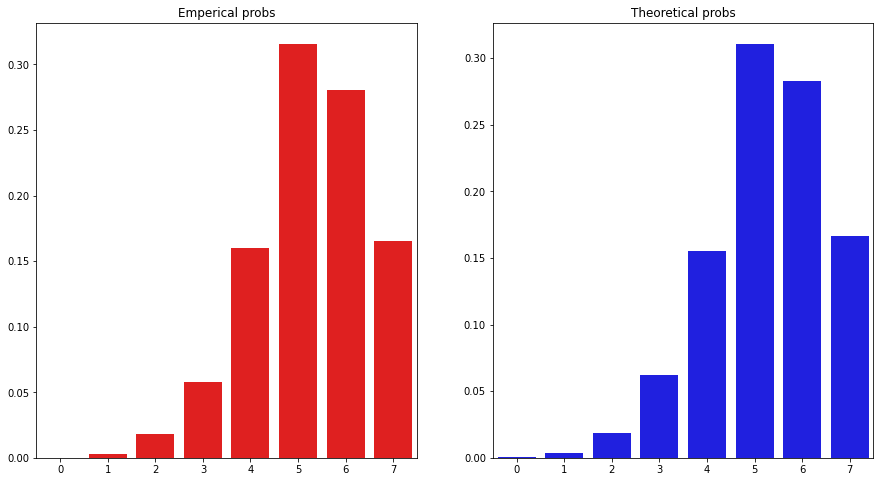

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].set_title("Emperical probs")
sns.barplot(x=np.arange(len(probs)), y=probs, color='red', ax=axes[0])

axes[1].set_title("Theoretical probs")
sns.barplot(x=np.arange(len(theoretical_probs)), y=theoretical_probs, color='blue', ax=axes[1]) ;

## Второй эксперимент

Параметры эксперимента:
 * количество каналов - 5
 * размер очереди - 5
 * интенсивность прихода в систему - 2
 * интенсивность обслуживания - 0.6
 * интенсивность выхода из очереди необслужанным - 1
 * отрезок времени симуляции - с 0 до 10000

In [22]:
simulator = Simulator(
    n_channels=5,
    queue_size=5,
    arr_rate=2.,
    serv_rate=0.6,
    rej_rate=1
)
simulator.start(10000)
probs, successes, failures = simulator.get_results()
theoretical_probs = simulator.theoretical_probas()

In [23]:
simulator.get_stats(probs)

{'Rejection probability': 0.0005907877988003109,
 'Absolute capacity': 1.9988184244023994,
 'Average requests in queue': 0.15105436607855596,
 'Average requests in system': 3.2137492976984805,
 'Average time in queue': 0.07552718303927798,
 'Average time in system': 1.6068746488492403,
 'Average busy channels': 3.0626949316199243}

In [24]:
simulator.get_stats(theoretical_probs)

{'Rejection probability': 0.0005971732208418231,
 'Absolute capacity': 1.9988056535583163,
 'Average requests in queue': 0.15048765165213945,
 'Average requests in system': 3.231017654829101,
 'Average time in queue': 0.07524382582606973,
 'Average time in system': 1.6155088274145506,
 'Average busy channels': 3.080530003176962}

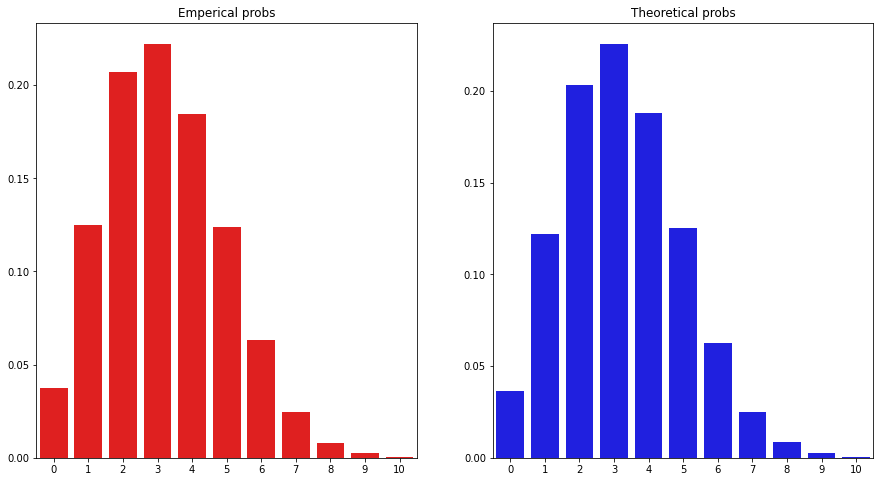

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].set_title("Emperical probs")
sns.barplot(x=np.arange(len(probs)), y=probs, color='red', ax=axes[0])

axes[1].set_title("Theoretical probs")
sns.barplot(x=np.arange(len(theoretical_probs)), y=theoretical_probs, color='blue', ax=axes[1]) ;

## Третий эксперимент

Параметры эксперимента:
 * количество каналов - 2
 * размер очереди - 10
 * интенсивность прихода в систему - 5
 * интенсивность обслуживания - 10
 * интенсивность выхода из очереди необслужанным - 10
 * отрезок времени симуляции - с 0 до 10000

In [26]:
simulator = Simulator(
    n_channels=2,
    queue_size=10,
    arr_rate=5.,
    serv_rate=10,
    rej_rate=10
)
simulator.start(10000)
probs, successes, failures = simulator.get_results()
theoretical_probs = simulator.theoretical_probas()

In [27]:
simulator.get_stats(probs)

{'Rejection probability': 3.0872010196554393e-13,
 'Absolute capacity': 4.999999999998456,
 'Average requests in queue': 0.015915685390739395,
 'Average requests in system': 0.4988700310262456,
 'Average time in queue': 0.0031831370781478787,
 'Average time in system': 0.09977400620524912,
 'Average busy channels': 0.4829543456355062}

In [28]:
simulator.get_stats(theoretical_probs)

{'Rejection probability': 3.0914045870390933e-13,
 'Absolute capacity': 4.999999999998455,
 'Average requests in queue': 0.016326649281447687,
 'Average requests in system': 0.49999999999984546,
 'Average time in queue': 0.0032653298562895375,
 'Average time in system': 0.09999999999996909,
 'Average busy channels': 0.4836733507183978}

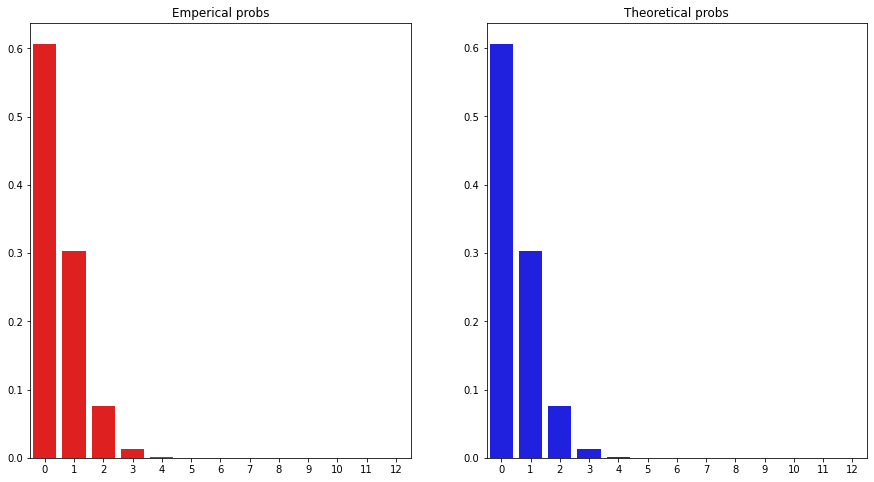

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].set_title("Emperical probs")
sns.barplot(x=np.arange(len(probs)), y=probs, color='red', ax=axes[0])

axes[1].set_title("Theoretical probs")
sns.barplot(x=np.arange(len(theoretical_probs)), y=theoretical_probs, color='blue', ax=axes[1]) ;